In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import seaborn as sns

In [3]:
from sklearn.metrics import accuracy_score, log_loss

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [115]:
train = pd.read_pickle('data/train_prep.pkl')
test = pd.read_pickle('data/test_prep.pkl')
sample = pd.read_csv('data/SubmissionFormat.csv')

In [116]:
duplic = train.columns.duplicated()
train = train.loc[:,~duplic]

In [117]:
test = test.loc[:,~duplic]

In [118]:
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [119]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

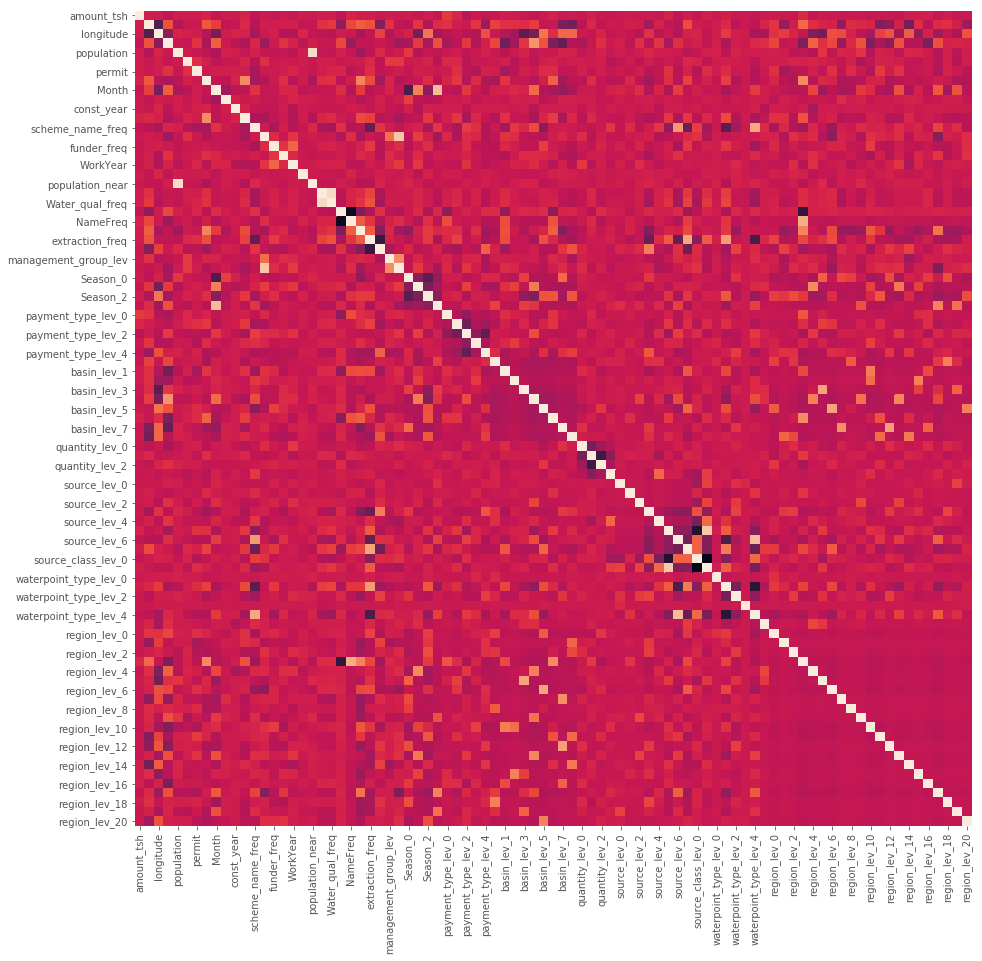

In [82]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), cbar=False)
plt.show()

In [83]:
outcome = pd.read_csv('data/Labels.csv', squeeze=True)

In [84]:
y = le.fit_transform(outcome.status_group)

In [85]:
pd.DataFrame(y).to_csv('data/Y.csv') 

In [86]:
# from pandas.core.common import array_equivalent

# def duplicate_columns(frame):
#     groups = frame.columns.to_series().groupby(frame.dtypes).groups
#     dups = []

#     for t, v in groups.items():

#         cs = frame[v].columns
#         vs = frame[v]
#         lcs = len(cs)

#         for i in range(lcs):
#             ia = vs.iloc[:,i].values
#             for j in range(i+1, lcs):
#                 ja = vs.iloc[:,j].values
#                 if array_equivalent(ia, ja):
#                     dups.append(cs[i])
#                     break

#     return dups

In [13]:
# dups = duplicate_columns(train)
# train = train.drop(dups, axis=1)

In [14]:
# dups = duplicate_columns(test)
# test = test.drop(dups, axis=1)

## Train-Test Split

In [87]:
X = train.copy()

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.15, random_state=42)

In [90]:
Xtr.shape, Xval.shape

((50490, 87), (8910, 87))

## Constant prediction

In [19]:
const = np.ones(shape=(8910, 1))*0

In [20]:
const

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [21]:
accuracy_score(yval, const)

0.5433221099887766

In [22]:
yval[1:50]

array([0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0,
       2, 0, 0, 2, 0])

In [23]:
probas = np.array(pd.Series(ytr).value_counts(normalize=True).sort_index().tolist())
probas

array([0.54303823, 0.07292533, 0.38403644])

In [24]:
log_loss(yval, np.tile(probas, 8910).reshape(8910, 3))

0.8871861089153322

In [25]:
pd.Series(ytr).value_counts(normalize=True).sort_index()

0    0.543038
1    0.072925
2    0.384036
dtype: float64

## Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xtr_scaled = scaler.fit_transform(Xtr)
Xval_scaled = scaler.transform(Xval)

In [92]:
lr = LogisticRegression()
lr.fit(Xtr_scaled, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr_scaled)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval_scaled)))

Train logloss 0.6737480348678361
Validation logloss 0.6739088562370541


In [94]:
print('Train accuracy score', accuracy_score(ytr, lr.predict(Xtr_scaled)))
print('Validation accuracy score', accuracy_score(yval, lr.predict(Xval_scaled)))

Train accuracy score 0.7046741929094871
Validation accuracy score 0.7077441077441078


### Hyperparameter optimization

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
Cs = 10**np.linspace(-4, 4, num=15)
Cs

array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04])

In [34]:
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=5, n_jobs=-1)

In [35]:
%time gridsearch.fit(Xtr_scaled, ytr)

CPU times: user 12.9 s, sys: 404 ms, total: 13.3 s
Wall time: 2min 35s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-04, 3.72759e-04, 1.38950e-03, 5.17947e-03, 1.93070e-02,
       7.19686e-02, 2.68270e-01, 1.00000e+00, 3.72759e+00, 1.38950e+01,
       5.17947e+01, 1.93070e+02, 7.19686e+02, 2.68270e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [ ]:
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


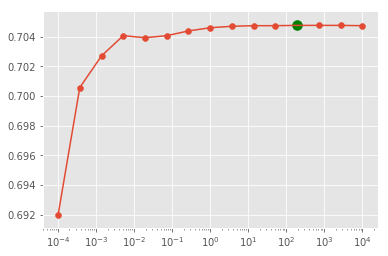

In [42]:
scores = [x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmax(scores)], scores[np.argmax(scores)], c='g', s=100)
plt.xscale('log')

In [43]:
C = Cs[np.argmax(scores)]
C

193.06977288832496

In [44]:
lr = LogisticRegression(C=C)
lr.fit(Xtr_scaled, ytr)
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr_scaled)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval_scaled)))
print('Train accuracy score', accuracy_score(ytr, lr.predict(Xtr_scaled)))
print('Validation accuracy score', accuracy_score(yval, lr.predict(Xval_scaled)))

Train logloss 0.6737452662399729
Validation logloss 0.6739032361093568
Train accuracy score 0.7047138047138047
Validation accuracy score 0.7078563411896746


## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf.fit(Xtr, ytr)
print(log_loss(yval, rf.predict_proba(Xval)))
print(accuracy_score(yval, rf.predict(Xval)))

0.5493459569195884
0.8123456790123457


In [47]:
answ = rf.predict(test)

In [48]:
answ = list(answ)

In [49]:
for i in range(len(answ)):
    if answ[i] == 0:
        answ[i] = 'functional'
    elif answ[i] == 1:
        answ[i] = 'functional needs repair'
    else:
        answ[i] = 'non functional'

In [50]:
answ[1:10]

['functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional']

In [51]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(answ, columns=sample.columns[1:])

In [52]:
sub.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [53]:
sub.to_csv('data/submission_rf.csv', index=False)

This random forest gave me 0.8076 score 

In [54]:
from sklearn.calibration import CalibratedClassifierCV

In [17]:
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=-1, n_estimators=200), cv=5, method='isotonic')
calib.fit(Xtr, ytr)
print(log_loss(yval, calib.predict_proba(Xval)))
print(accuracy_score(yval, calib.predict(Xval)))

0.477490658757
0.816049382716


In [18]:
answ = calib.predict(test)
answ = list(answ)

In [121]:
def classes_to_names(answ):
    clean = answ
    for i in range(len(answ)):
        if answ[i] == 0:
            clean[i] = 'functional'
        elif answ[i] == 1:
            clean[i] = 'functional needs repair'
        else:
            clean[i] = 'non functional'
    return clean

In [ ]:
answ = classes_to_names(answ)

In [19]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(answ, columns=sample.columns[1:])

In [20]:
sub.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [21]:
sub.to_csv('/home/dmitry/Desktop/DataDriven/submission.csv', index=False)

## XGBoost

In [57]:
import xgboost as xgb

In [104]:
from xgboost import XGBClassifier

In [105]:
xgb = XGBClassifier(max_depth=8, n_estimators=100, silent=False, objective='multi:softmax', colsample_bylevel=0.8)

In [106]:
xgb.fit(Xtr, ytr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [109]:
xgb.score(Xtr, ytr)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8439492968904734

In [110]:
xgb = XGBClassifier(max_depth=8, n_estimators=1000, objective='multi:softmax', colsample_bylevel=0.8)
xgb.fit(Xtr, ytr)
xgb.score(Xtr, ytr)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9859180035650624

In [111]:
xgb.score(Xval, yval)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.810662177328844

In [122]:
answ = xgb.predict(test)

In [123]:
answ = classes_to_names(list(answ))

In [124]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(answ, columns=sample.columns[1:])

In [125]:
sub.to_csv('data/xgb_prediction.csv', index=False)

Score is 0.8148, current best on the leaderboard is 0.8286

## Neural Networks

In [127]:
Xtr.shape

(50490, 87)

In [179]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim.lr_scheduler import StepLR

def compute_accuracy(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        x = torch.tensor(x, device=device, dtype=torch.float)
        y = torch.tensor(y, device=device, dtype=torch.float)
        outputs = mlp.forward(x)
        accuracy = accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), y)
        return accuracy

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Train Epoch {}: Train acc {:.4f} Validation acc {:.4f}'.format(
        epoch, train_error, val_error))
    
class EarlyStoping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int): Maximum number of epochs with unsuccessful updates
          tolerance (int): We assume that the update is unsuccessful if the validation error is larger
                            than the best validation error so far plus this tolerance
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_acc):
        """
        Args:
          val_errors (iterable): Validation accuracy after every update during training
        
        Returns: True if training should be stopped: when the validation accuracy is smaller than the best
                  validation accuracy obtained so far (with given tolearance) for patience epochs.
                 Otherwise returns False.
        """

        if sum(val_acc[-self.patience:] < np.max(val_acc)-self.tolerance) >= self.patience:
            return True
        else:
            return False

In [190]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(87, 300),
            #nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(300, 100),
            #nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(100, 100),
            #nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(100, 50),
            #nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(50, 3),
            nn.Softmax())

    def forward(self, x):
        return self.net(x)

In [192]:
device = torch.device("cpu")

mlp = MLP()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
n_epochs = 2000
early_stop = EarlyStoping(tolerance=0.01, patience=30)
train_acc = []  # Keep track of the training data
val_acc = []  # Keep track of the validation data
for epoch in range(n_epochs):
    x = torch.tensor(Xtr_scaled, device=device, dtype=torch.float)
    y = torch.tensor(ytr, device=device)

    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_acc.append(compute_accuracy(mlp, Xtr_scaled, ytr))
    val_acc.append(compute_accuracy(mlp, Xval_scaled, yval))

    if early_stop.stop_criterion(val_acc):
        print(val_acc[epoch])
        print('Stop after %d epochs' % epoch)
        break
    
    if (epoch % 10) == 0:
        print_progress(epoch, train_acc[-1], val_acc[-1])

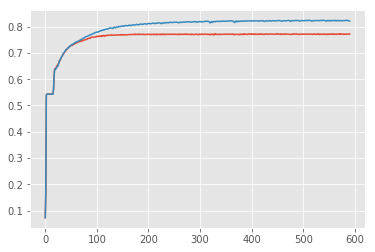

In [194]:
plt.plot(val_acc)
plt.plot(train_acc)